In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/diabetes-dataset/diabetes.csv')

## EDA(Exploratory Data Analysis)

In [3]:
def eda(dataframe):
    print(f"""
    
    -- dtypes --
    
    {dataframe.dtypes}
    
    -- NaN Values --
    
    {dataframe.isnull().sum()}
    
    -- Shape --
    
    {dataframe.shape}
    
    -- Unique --
    
    {df.apply(lambda x: x.nunique())}
    
    -- Head --
    """)
    
    
    return dataframe.head()
eda(df)


    
    -- dtypes --
    
    Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
    
    -- NaN Values --
    
    Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
    
    -- Shape --
    
    (768, 9)
    
    -- Unique --
    
    Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age               

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


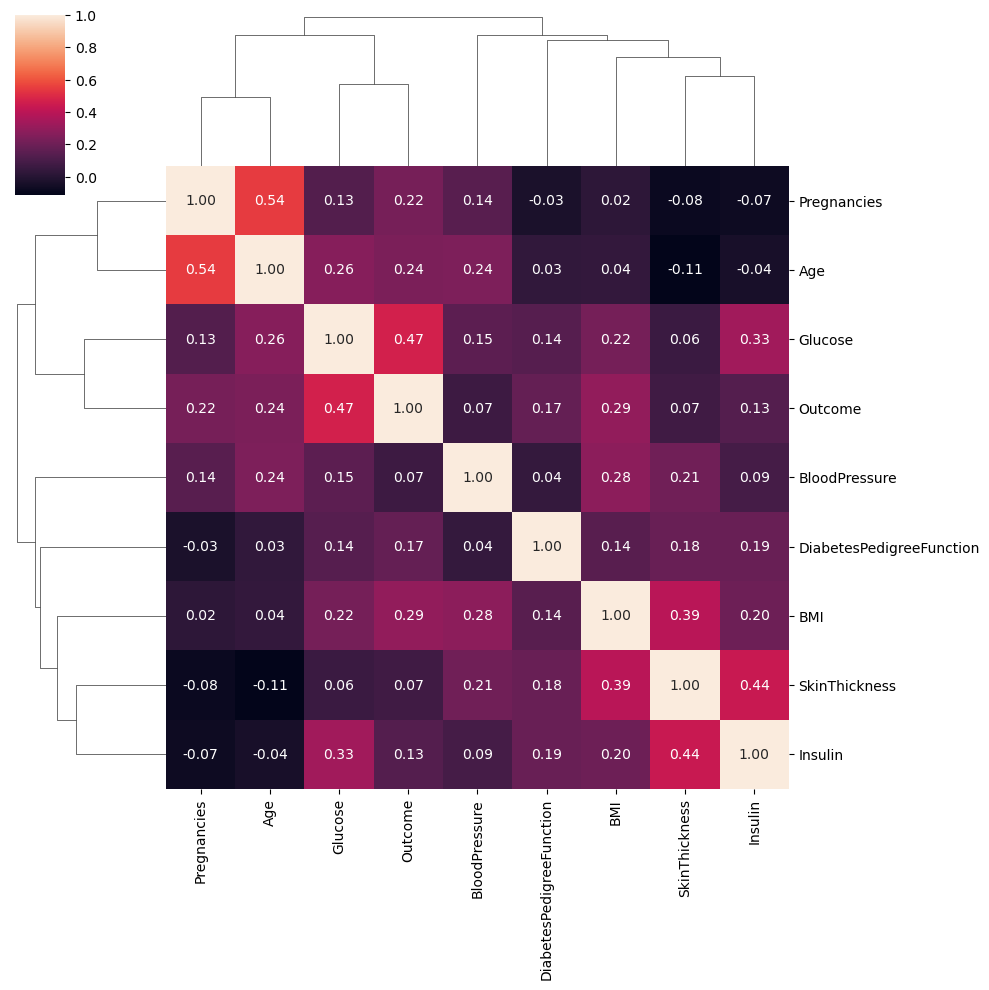

In [5]:
sbn.clustermap(df.corr(), annot = True, fmt = ".2f")

# Data Pre-Processing

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [7]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [8]:
cat_cols, num_cols, cat_but_car

(['Outcome'],
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'],
 [])

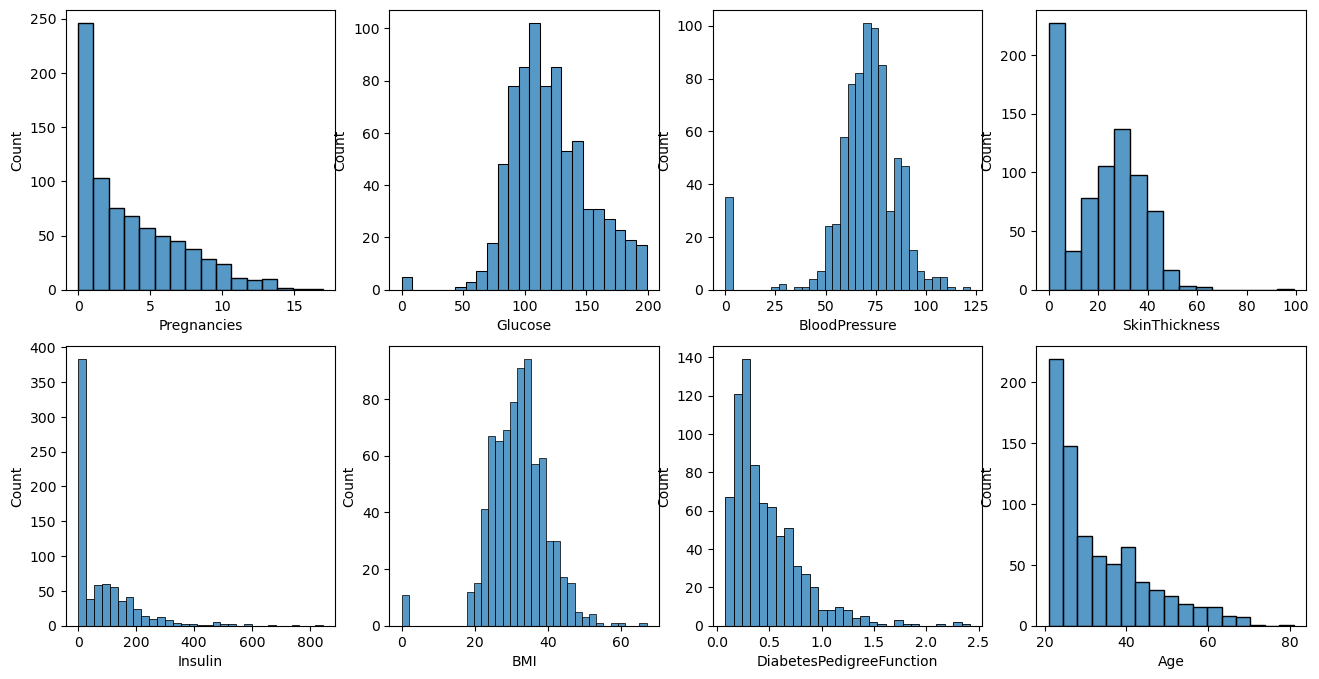

In [9]:
plt.figure(figsize = (16,8))
for i,x in enumerate(num_cols):
  plt.subplot(2,4,i+1)
  sbn.histplot(df[x])

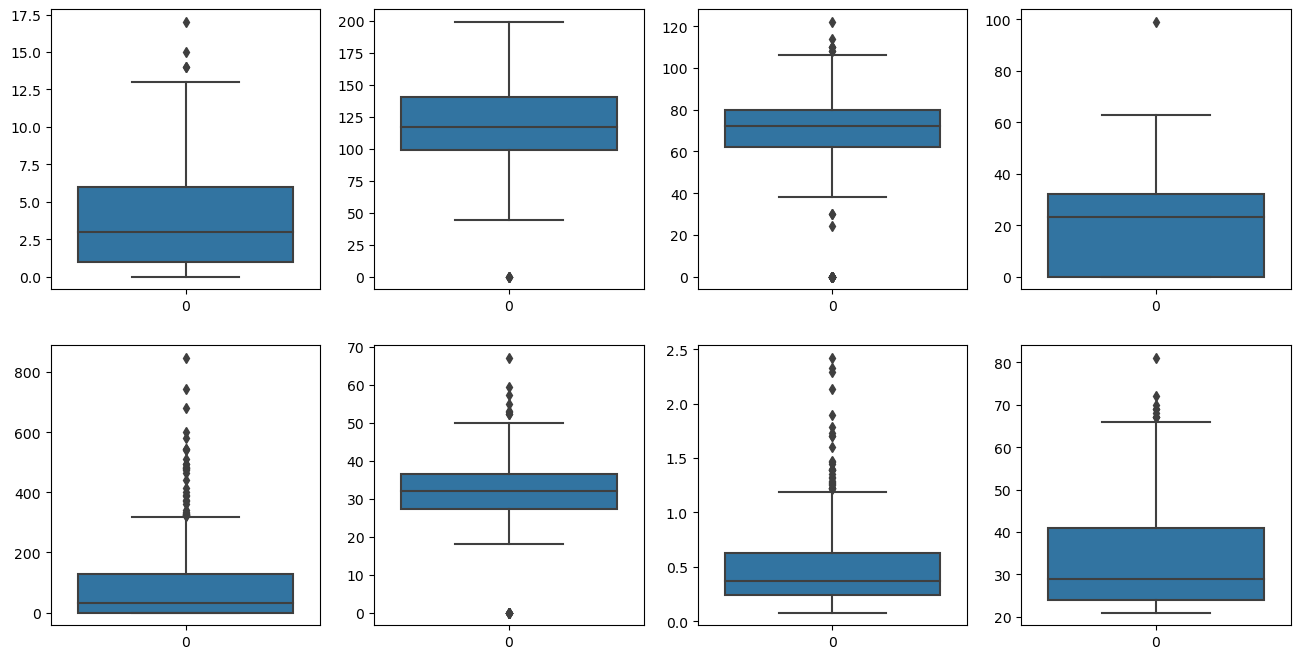

In [10]:
plt.figure(figsize = (16,8))
for i,x in enumerate(num_cols):
  plt.subplot(2,4,i+1)
  sbn.boxplot(df[x])

### Outlier Analysis

In [11]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [12]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [13]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [14]:
for x in num_cols:
  print(x,check_outlier(df,x))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


In [15]:
for x in num_cols:
  replace_with_thresholds(df,x)

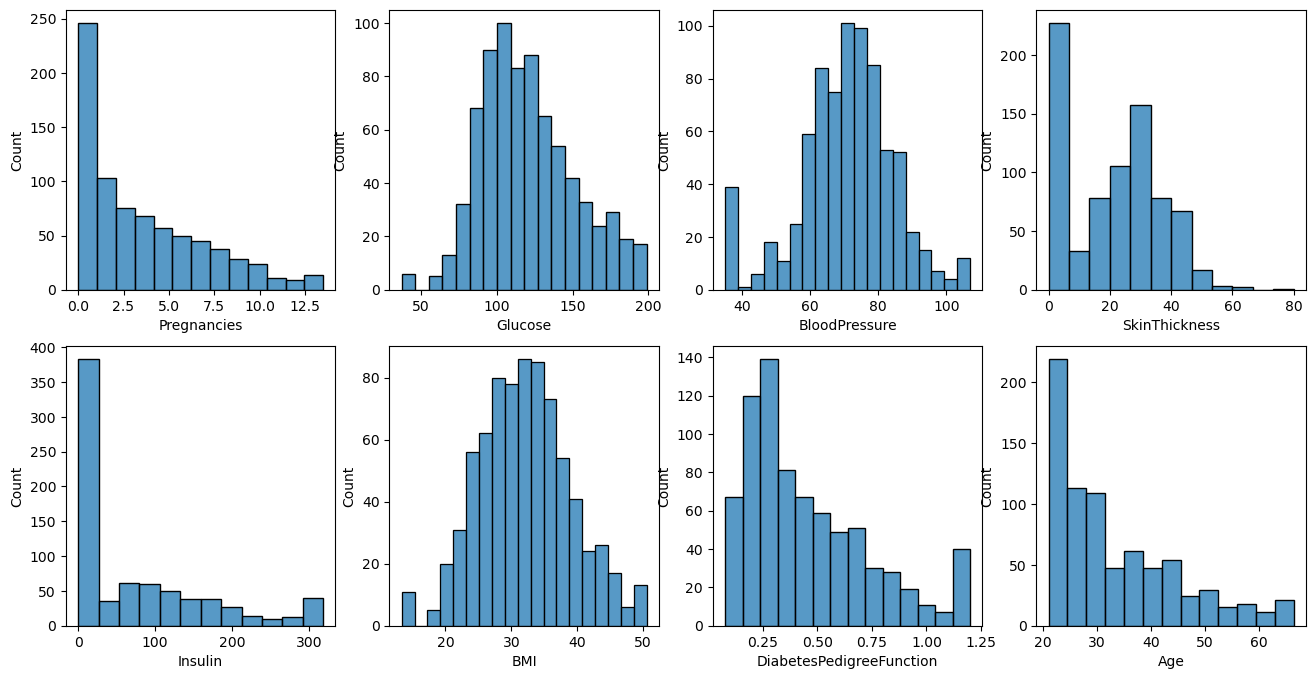

In [16]:
plt.figure(figsize = (16,8))
for i,x in enumerate(num_cols):
  plt.subplot(2,4,i+1)
  sbn.histplot(df[x])

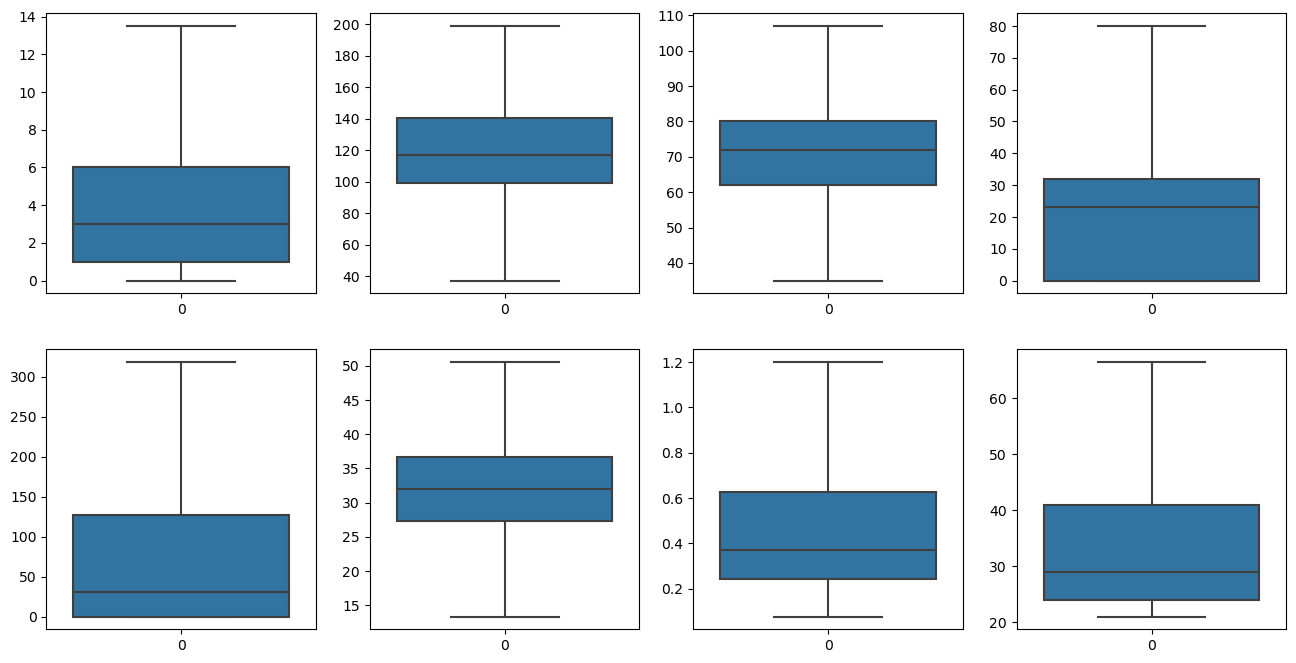

In [17]:
plt.figure(figsize = (16,8))
for i,x in enumerate(num_cols):
  plt.subplot(2,4,i+1)
  sbn.boxplot(df[x])

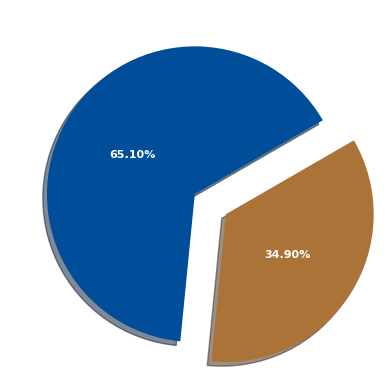

In [18]:
plt.pie(df['Outcome'].value_counts(),
                   explode      = [0.0, 0.25], 
                   startangle   = 30, 
                   shadow       = True, 
                   colors       = ['#004d99', '#ac7339'], 
                   textprops    = {'fontsize': 8, 'fontweight': 'bold', 'color': 'white'},
                   pctdistance  = 0.50, autopct = '%1.2f%%'
                  );

Visible Outlier data has been fixed, but there are also hidden ones. These hidden outliers data are "Insulin and SkinThickness"
Their min value is 0, but these values ​​cannot be 0. We will make these 0 values ​​NaN and fill them with mean

In [19]:
df.describe()[['Insulin','SkinThickness']].loc['min',:] 

Insulin          0.0
SkinThickness    0.0
Name: min, dtype: float64

As you can see they have a value of 0.

Let's look at the number and ratio of these values

In [20]:
zero_count = pd.DataFrame(df[['Insulin','SkinThickness']].apply(lambda x: x.value_counts()).loc[0,:])
zero_ratio = zero_count /df[['Insulin','SkinThickness']].shape[0]

pd.concat([zero_count,zero_ratio], axis = 1)

,0.0,0.0
Insulin,374.0,0.486979
SkinThickness,227.0,0.295573


It's a lot too :D Let's fix them ;)

In [21]:
df['Insulin'] = df['Insulin'].where((df['Insulin'] > 0)).fillna(df.groupby('Outcome')["Insulin"].transform("mean"))
df['SkinThickness'] = df['SkinThickness'].where((df['SkinThickness'] > 0)).fillna(df.groupby('Outcome')["SkinThickness"].transform("mean"))

In [22]:
df.describe()[['Insulin','SkinThickness']].loc['min',:]

Insulin          14.0
SkinThickness     7.0
Name: min, dtype: float64

yeah that's better

# Feature Engineering

<AxesSubplot:xlabel='Age', ylabel='Count'>

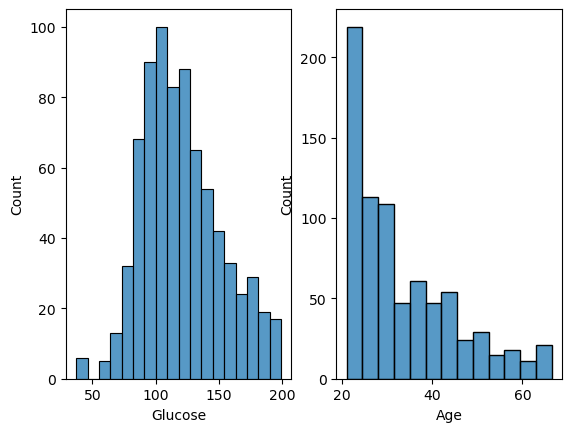

In [23]:
plt.subplot(1,2,1)
sbn.histplot(df['Glucose'])
plt.subplot(1,2,2)
sbn.histplot(df['Age'])

I think there may be a link between glucose and age. that is, the glucose value of an old person and the glucose value of a young person will not give the same effect at the same level.

It is normal for a young person to have glucose levels between 50 and 150

In [24]:
df.loc[(df['Glucose'] < 150) & (df['Glucose'] > 50) & (df["Age"] <= 45), "Gul_Age_Cat"] = "normal_young"
df.loc[(df['Glucose'] < 150) & (df['Glucose'] > 50) & (df["Age"] > 45), "Gul_Age_Cat"] = "normal_old"
df.loc[((df['Glucose'] > 150) | (df['Glucose'] < 50)) & (df["Age"] <= 45), "Gul_Age_Cat"] = "not_normal_young"
df.loc[((df['Glucose'] > 150) | (df['Glucose'] < 50)) & (df["Age"] > 45), "Gul_Age_Cat"] = "not_normal_old"

I categorized the insulin values

In [25]:
df.loc[(df['Insulin'] < 30), "Insulin_level"] = "Low"
df.loc[(df['Insulin'] >= 30) & (df['Insulin'] <= 120), "Insulin_level"] = "Normal"
df.loc[(df['Insulin'] >120), "Insulin_level"] = "High"


I wanted to see if it would have an effect by categorizing glucose values ​​as well.

In [26]:
df.loc[(df['Glucose'] < 50), "Glucose_level"] = "Low"
df.loc[(df['Glucose'] >= 50) & (df['Glucose'] <= 140), "Insulin_level"] = "Normal"
df.loc[(df['Glucose'] >140), "Glucose_level"] = "High"

I brought together the variables that have a high impact on diabetes and gave the value "At_Risk" to those that had at least one value in the "Not_Risk" risk zone for those with normal values.

In [27]:
df.loc[((df['Insulin'] >= 50) & (df['Insulin'] <= 140)) & 
       ((df['BMI'] >= 25) & (df['BMI'] <= 36)) & 
       ((df['Glucose'] >= 50) & (df['Glucose'] <= 150)) &
       ((df['SkinThickness'] >= 20) & (df['SkinThickness'] <= 32))
       , "Life_level"] = "Not_Risk"
df['Life_level'].fillna('At_Risk',inplace = True)

<AxesSubplot:xlabel='BMI', ylabel='Count'>

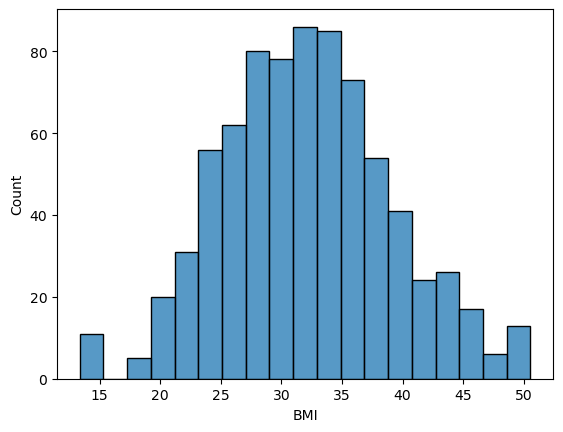

In [28]:
sbn.histplot(df['BMI'])

I categorized the BMI Variable in the ranges I specified

In [29]:
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

<AxesSubplot:xlabel='BloodPressure', ylabel='Count'>

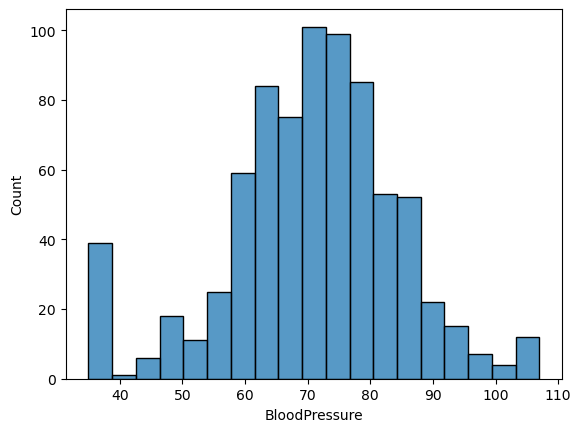

In [30]:
sbn.histplot(df['BloodPressure'])

I categorized the BloodPressure Variable in the ranges I specified

In [31]:
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BloodPressure'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

In [32]:
df[cat_cols] = df[cat_cols].astype('category')

df_dummy = pd.get_dummies(df,drop_first = True)
df_dummy.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome_1,Gul_Age_Cat_normal_young,...,Gul_Age_Cat_not_normal_young,Insulin_level_Low,Insulin_level_Normal,Glucose_level_Low,Life_level_Not_Risk,NEW_BMI_RANGE_healty,NEW_BMI_RANGE_overweight,NEW_BMI_RANGE_obese,NEW_BLOODPRESSURE_hs1,NEW_BLOODPRESSURE_hs2
0,6.0,148.0,72,35.000000,89.583489,33.6,0.627,50.0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,1.0,85.0,66,29.000000,65.113750,26.6,0.351,31.0,0,1,...,0,0,1,0,1,0,1,0,0,0
2,8.0,183.0,64,22.093284,89.583489,23.3,0.672,32.0,1,0,...,1,0,1,0,0,1,0,0,0,0
3,1.0,89.0,66,23.000000,94.000000,28.1,0.167,21.0,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0.0,137.0,40,35.000000,168.000000,43.1,1.200,33.0,1,1,...,0,0,1,0,0,0,0,1,0,0


### Scaling

Scaling is the process of scaling data features. Data features can be measured in different ranges or units, which can be important for machine learning algorithms. For example, suppose there are two features in a dataset: "age" and "income". Age values can be measured in a range of 0-100, while income values can vary from thousands of dollars to hundreds of thousands of dollars. In this case, machine learning algorithms may give more importance to the income feature and ignore the effect of the age feature. Therefore, when scaling data features, each feature is transformed to be on the same scale. This process allows the data set to be properly analyzed and more accurate predictions to be made. Scaling can be performed using different methods such as standardization, normalization, or min-max scaling.


In [33]:
X_scaled = StandardScaler().fit_transform(df_dummy[num_cols])
df_dummy[num_cols] = pd.DataFrame(X_scaled, columns=df_dummy[num_cols].columns)

In [34]:
y = df["Outcome"]
x = df_dummy.drop('Outcome_1',axis = 1)

# Create Models

In [35]:
def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [36]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [37]:
def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [38]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [39]:
def fit(x,y):
    base_models(x, y)
    best_models = hyperparameter_optimization(x, y)
    voting_clf = voting_classifier(best_models, x, y)
    joblib.dump(voting_clf, "voting_clf.pkl")
    return voting_clf,best_models

In [ ]:
voting_clf,best_models = fit(x,y)

Base Models....
accuracy: 0.7813 (LR) 
accuracy: 0.7722 (KNN) 
accuracy: 0.8048 (SVC) 
accuracy: 0.8516 (CART) 
accuracy: 0.8855 (RF) 
accuracy: 0.8789 (Adaboost) 
accuracy: 0.8881 (GBM) 
accuracy: 0.8894 (XGBoost) 
accuracy: 0.8933 (LightGBM) 
Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.7722
accuracy (After): 0.7878
KNN best params: {'n_neighbors': 17}

########## CART ##########
accuracy (Before): 0.8568
accuracy (After): 0.8711
CART best params: {'max_depth': 9, 'min_samples_split': 10}

########## RF ##########
accuracy (Before): 0.8751


lightGBM gave the best results

In [ ]:
voting_clf

In [ ]:
lgbm = best_models['LightGBM'].fit(x,y)

### Feature Importances

In [ ]:
feature_imp = pd.DataFrame({"Value": lgbm.feature_importances_, 'Feature':x.columns})
plt.figure(figsize=(10, 10))
sbn.set(font_scale=1)
sbn.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.xlabel("Variable Importance Level ")
plt.show()

### ROC (Receiver Operating Characteristic) Curve

In [ ]:
logit_roc_auc = roc_auc_score(y, lgbm.predict(x))
fpr, tpr, thresholds = roc_curve(y, lgbm.predict_proba(x)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC eğrisi')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Rastgele tahmin')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Conclusion

Thank you for reading my notebook and for your votes. If you like it, I will be glad if you do not forget to support me :)